In [ ]:
import numpy as np
from scipy.stats import binom

**`Initial Revenue and Cost Analysis`**

In [ ]:
"""
airline

two types of tickets:
- main cabin
- first class

overbooking:
- only allowed for main cabin
- overbooked main cabin can use first class if there are spaces left
    -> This will incur a cost for the airline, cost_1
- overbooked that don't have a seat available:
    -> This will incur another cost for the airline cost_2


selling:
- everyday we can sell or not a ticket for each type
- we have to possible prices to charge, High or Low, for both types
- demand for each class is independent
    - each type of ticket has their own probability distribution
    - when first class is sold out, probability of sale in coach is +3%
"""

T=365  # 365 days before the plane departs
coach_seats = 100  # 100 seats for main cabin
first_seats = 20  # 20 seats for first class

coach_showup_prob = 0.95  # 95% prob of coach ticket holder to show up
first_showup_prob = 0.97  # 97% prob of first class ticket holder to show

coach_price_L = 300  # coach ticket low price
coach_price_H = 350  # coach ticket high price
first_price_L = 425  # first class ticket low price
first_price_H = 500  # first class ticket high price

# Coach Low and High sale probabilities
coach_L_sale_prob = 0.65
coach_H_sale_prob = 0.30

# First class Low and High sale probabilities
first_L_sale_prob = 0.08
first_H_sale_prob = 0.04

# price_combinations
price_comb = np.array([
    [coach_price_L, first_price_L],
    [coach_price_L, first_price_H],
    [coach_price_H, first_price_L],
    [coach_price_H, first_price_H]
])

prob_comb = np.array([
    [coach_L_sale_prob, first_L_sale_prob],
    [coach_L_sale_prob, first_H_sale_prob],
    [coach_H_sale_prob, first_L_sale_prob],
    [coach_H_sale_prob, first_H_sale_prob]
])

overbooking = 5  # number of seats we can overbook

upgrade_cost = 50  # cost of upgrading coach to first class
bump_cost = 425  # cost of leaving passenger on the ground

discount_rate = 0.17
daily_d =  1/(1+(discount_rate/365))

In [ ]:
"""
Value Function V(coach_seats, first_class, t),
"""
V = np.zeros((coach_seats + overbooking+1, first_seats+1, T+1))
P_selection = np.zeros((coach_seats + overbooking+1, first_seats+1, T))
# For price selection:
# 0 = Lc - Lf
# 1 = Lc - Hf
# 2 = Hc - Lf
# 3 = Hc - Hf

coach_options = np.arange(coach_seats+overbooking+1)
first_options = np.arange(first_seats+1)

In [ ]:
V.shape

(106, 21, 366)

In [ ]:
"""
Terminal Value for V(T)
"""
def fill_terminal_value():
    # For each pair scenario of coach and first class tickets sold
    for coach in coach_options:
        for first in first_options:
            # Each pair scenario of coach and first class that they show up
            # initialize value_fn
            value_fn = 0
            for showup_coach in range(coach+1):
                for showup_first in range(first+1):
                    # print(f'Scenario, coach tickets: {coach},\tfirst class tickets: {first},\tshowup_coach: {showup_coach},\tshowup_first: {showup_first}') ## Debugging purposes

                    # overbooking has occurred
                    if showup_coach > coach_seats:
                        overbook = showup_coach - coach_seats
                        free_seats_first = first_seats - showup_first
                        assigned_to_first = overbook if free_seats_first > overbook else free_seats_first

                        prob_scenario_coach = binom.pmf(showup_coach, coach, coach_showup_prob)
                        prob_scenario_first = binom.pmf(showup_first, first, first_showup_prob)
                        # Value function = (cost of upgrading to first class + cost of bumping of the plane) * probability of this scenario to happen
                        value_fn += -(upgrade_cost*assigned_to_first + bump_cost*(overbook-assigned_to_first)) * prob_scenario_coach * prob_scenario_first
                    # no overbooking
                    else:
                        value_fn += 0


            V[coach][first][T] = value_fn

fill_terminal_value()

In [ ]:
# iterate through all combinations of p
coach = 100
first = 20

# if price is low low
p = price_comb[0]
prob = prob_comb[0]

def get_revenue_today(coach, first, ti,As p, prob):
    """
    This function calculates the Value function for a defined number of:
    - coach tickets sold
    - first tickets sold
    - time period
    - probabilities
    """
    # check if we have both types of seats to sell
    if coach < (coach_seats + overbooking) and first < first_seats:
        #print('Tickets available for both')
        # Calculate revenue through all possible outcomes
        #           sell - sell                   sell - not sell                not sell - sell                not sell - not sell
        rev_today = (p[0]+p[1])*prob[0]*prob[1] + (p[0]+0)*prob[0]*(1-prob[1]) + (0+p[1])*(1-prob[0])*prob[1] + (0+0)*(1-prob[0])*(1-prob[1])

        # We don't know what will happen tomorrow
        #                   sell - sell                              sell - not sell                               not sell - sell                              not sell - not sell
        rev_tomorrow = V[coach+1][first+1][ti+1]*prob[0]*prob[1] + V[coach+1][first][ti+1]*prob[0]*(1-prob[1]) + V[coach][first+1][ti+1]*(1-prob[0])*prob[1] + V[coach][first][ti+1]*(1-prob[0])*(1-prob[1])

    # check if we have sold out first class
    elif coach < (coach_seats + overbooking) and first == first_seats:
        #print('Sold out first class')
        # Calculate revenue through all possible outcomes
        # first class sold out prob increases 3%
        #           sell                   not sell
        rev_today = p[0]*(prob[0]+0.03) + 0*(1-prob[0]-0.03)

        # We don't know what will happen tomorrow
        #                   sell                                  not sell
        rev_tomorrow = V[coach+1][first][ti+1]*(prob[0]+0.03) +  V[coach][first][ti+1]*(1-prob[0]-0.03)

    # check if we have sold out first class
    elif coach == (coach_seats + overbooking) and first < first_seats:
        #print('Sold out first coach')
        # Calculate revenue through all possible outcomes
        #           sell           not sell
        rev_today = p[1]*prob[1] + 0*(1-prob[1])

        # We don't know what will happen tomorrow
        #                       sell                               not sell
        rev_tomorrow = V[coach][first+1][ti+1]*prob[1] +  V[coach][first][ti+1]*(1-prob[1])

    # no seats available to sell
    else:
        #print('Sold out both')
        rev_today = 0
        rev_tomorrow = V[coach][first][ti+1]

    #print(f'Revenue today: {rev_today}, revenue_tomorrow: {rev_tomorrow}')
    return rev_today + daily_d*rev_tomorrow

print(get_revenue_today(coach, first, 363, p, prob))

204.00000000000003


In [ ]:
"""
Fill up V(c, f, ti) going from last day to today
"""
def fill_value_function():
    # Go back in time :)
    for ti in reversed(range(T)):
        # loop through all pair scenario of coach and first class tickets sold
        # value function of coach and fairst prices option

        for coach in coach_options:
            for first in first_options:
                #print(f'coach: {coach}, first: {first}, ti: {ti}')
                value_options = [get_revenue_today(coach, first, ti, price_comb[i], prob_comb[i]) for i in range(len(price_comb))]
                # get value for each one of the possible decisions we have
                # Lc - Lf, Lc - Hf, Hc - Lf, Hc - Hf

                # get best value_option
                #print(value_options)
                #print(np.max(value_options))
                #print(np.argmax(value_options))
                V[coach][first][ti] = np.max(value_options)
                P_selection[coach][first][ti] = np.argmax(value_options)

fill_value_function()

In [ ]:
# Value at initial time when we have no seats sold and it's time 0
V[0][0][0]

41886.158624195705

In [ ]:
P_selection[0][0][0]

2.0

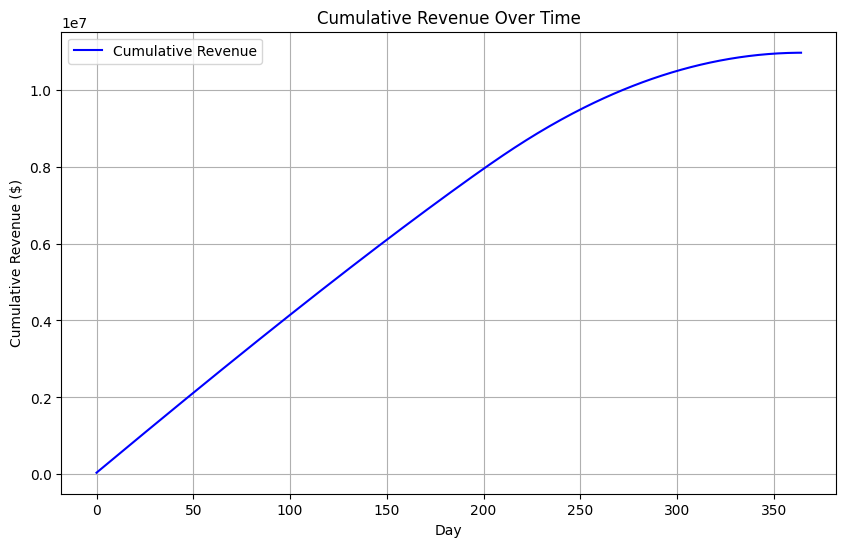

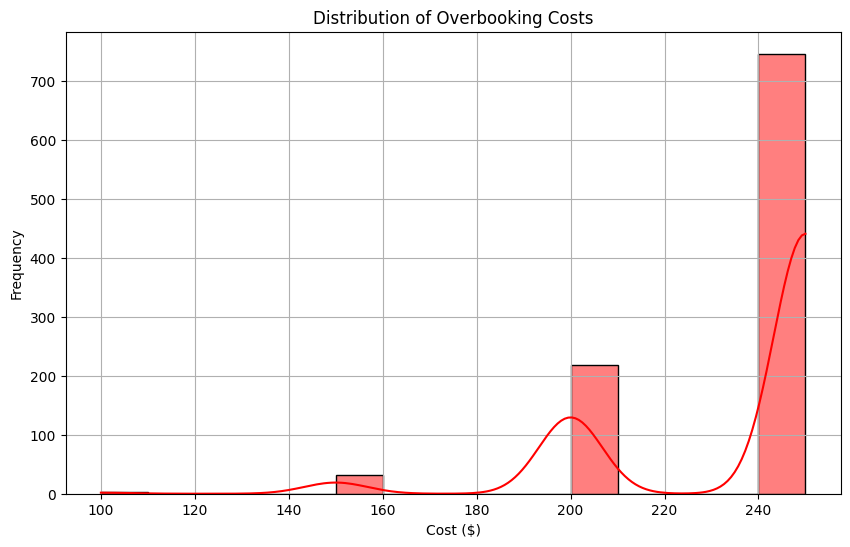

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization 1: Cumulative Revenue Curve
def plot_cumulative_revenue(V):
    cumulative_revenue = np.cumsum([V[0][0][t] for t in range(T)])
    plt.figure(figsize=(10, 6))
    plt.plot(range(T), cumulative_revenue, label='Cumulative Revenue', color='blue')
    plt.xlabel('Day')
    plt.ylabel('Cumulative Revenue ($)')
    plt.title('Cumulative Revenue Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_cumulative_revenue(V)

# Visualization 2: Overbooking Cost Distribution
def plot_overbooking_costs():
    costs = []
    # Simulate overbooking scenarios
    for _ in range(1000):  # Simulate 1000 flights
        sold_tickets = coach_seats + np.random.binomial(overbooking, coach_showup_prob)  # Assume overbooking tickets are sold and calculate show-ups
        if sold_tickets > coach_seats:
            overbooked = sold_tickets - coach_seats
            bumped_to_first = min(overbooked, first_seats)  # Assume some overbooked can be bumped to first class
            bumped_off = overbooked - bumped_to_first
            costs.append(upgrade_cost*bumped_to_first + bump_cost*bumped_off)
        else:
            costs.append(0)

    plt.figure(figsize=(10, 6))
    sns.histplot(costs, kde=True, color='red')
    plt.xlabel('Cost ($)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Overbooking Costs')
    plt.grid(True)
    plt.show()

plot_overbooking_costs()

#### Repeat this process for overbooking 6,7,...,15

In [ ]:
overbooking_values = np.arange(5,16)
expected_profits = np.zeros(len(overbooking_values))
pricing_policy = {}

for i in range(len(overbooking_values)):

    overbooking = overbooking_values[i]
    V = np.zeros((coach_seats + overbooking+1, first_seats+1, T+1))
    P_selection = np.zeros((coach_seats + overbooking+1, first_seats+1, T))
    # For price selection:
    # 0 = Lc - Lf
    # 1 = Lc - Hf
    # 2 = Hc - Lf
    # 3 = Hc - Hf

    coach_options = np.arange(coach_seats+overbooking+1)
    first_options = np.arange(first_seats+1)

    fill_terminal_value()
    fill_value_function()

    # Results
    expected_profits[i] = V[0][0][0]
    pricing_policy[i] = P_selection
    print(f'Seats available for booking: {overbooking}, Exepcted profit: {V[0][0][0]}')


Seats available for booking: 5, Exepcted profit: 41886.158624195705
Seats available for booking: 6, Exepcted profit: 42011.22106044435
Seats available for booking: 7, Exepcted profit: 42085.53615582861
Seats available for booking: 8, Exepcted profit: 42122.167268762896
Seats available for booking: 9, Exepcted profit: 42134.62483034151
Seats available for booking: 10, Exepcted profit: 42132.900382350956
Seats available for booking: 11, Exepcted profit: 42123.66593558059
Seats available for booking: 12, Exepcted profit: 42111.029670478485
Seats available for booking: 13, Exepcted profit: 42097.41950987721
Seats available for booking: 14, Exepcted profit: 42084.111570352936
Seats available for booking: 15, Exepcted profit: 42071.74230930781


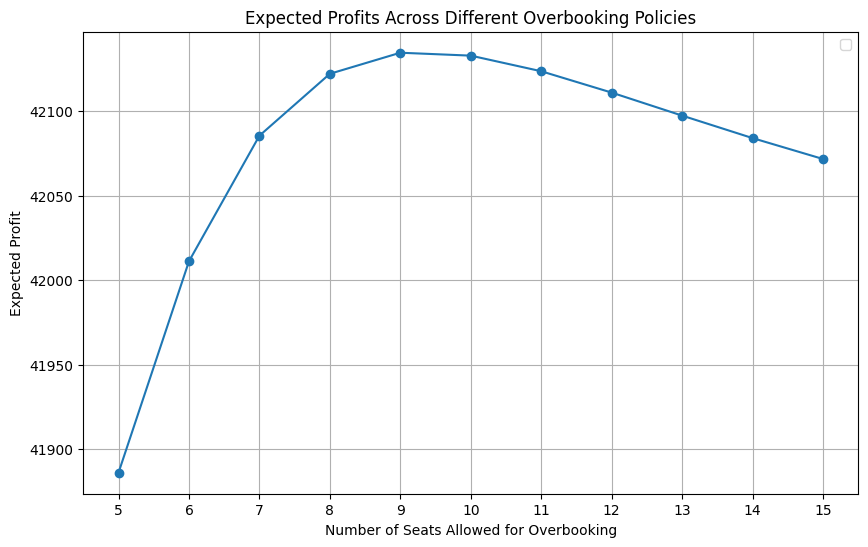

In [ ]:
# Given data from the user
overbooking_values = np.arange(5, 16)

# Assuming the setup and function definitions provided above have been executed,
# this code snippet will directly use the calculated 'expected_profits' from the simulation.

# Now we want to plot the expected profits to compare different overbooking policies.

plt.figure(figsize=(10, 6))
plt.plot(overbooking_values, expected_profits, '-o')
plt.title('Expected Profits Across Different Overbooking Policies')
plt.xticks(np.arange(5, 16, 1))
plt.xlabel('Number of Seats Allowed for Overbooking')
plt.ylabel('Expected Profit')
plt.grid(True)
plt.legend()
plt.show()

### Implement new policy

In [ ]:
"""
Here you need to create a copy of the function fill_value_function to include the new option,
also change price_comb, prob_comb, and P_selection will now include the two new options
"""
T=365  # 365 days before the plane departs
coach_seats = 100  # 100 seats for main cabin
first_seats = 20  # 20 seats for first class

# Add no coach sale scenario
price_comb_new = np.array([
    [coach_price_L, first_price_L],
    [coach_price_L, first_price_H],
    [coach_price_H, first_price_L],
    [coach_price_H, first_price_H],
    [0, first_price_L],  # No coach sale scenario, lower first class price
    [0, first_price_H]   # No coach sale scenario, higher first class price
])

prob_comb_new = np.array([
    [coach_L_sale_prob, first_L_sale_prob],
    [coach_L_sale_prob, first_H_sale_prob],
    [coach_H_sale_prob, first_L_sale_prob],
    [coach_H_sale_prob, first_H_sale_prob],
    [0, first_L_sale_prob],  # No coach sale scenario, lower first class sale probability
    [0, first_H_sale_prob]   # No coach sale scenario, higher first class sale probability
])
#V = np.zeros((coach_seats + overbooking+1, first_seats+1, T+1))

def fill_terminal_value():
    # For each pair scenario of coach and first class tickets sold
    for coach in coach_options:
        for first in first_options:
            # Each pair scenario of coach and first class that they show up
            # initialize value_fn
            value_fn = 0
            for showup_coach in range(coach+1):
                for showup_first in range(first+1):
                    # print(f'Scenario, coach tickets: {coach},\tfirst class tickets: {first},\tshowup_coach: {showup_coach},\tshowup_first: {showup_first}') ## Debugging purposes

                    # overbooking has occurred
                    if showup_coach > coach_seats:
                        overbook = showup_coach - coach_seats
                        free_seats_first = first_seats - showup_first
                        assigned_to_first = overbook if free_seats_first > overbook else free_seats_first

                        prob_scenario_coach = binom.pmf(showup_coach, coach, coach_showup_prob)
                        prob_scenario_first = binom.pmf(showup_first, first, first_showup_prob)
                        # Value function = (cost of upgrading to first class + cost of bumping of the plane) * probability of this scenario to happen
                        value_fn += -(upgrade_cost*assigned_to_first + bump_cost*(overbook-assigned_to_first)) * prob_scenario_coach * prob_scenario_first
                    # no overbooking
                    else:
                        value_fn += 0

            V[coach][first][T] = value_fn


def fill_value_function_new():

    for ti in reversed(range(T)):
        for coach in coach_options:
            for first in first_options:

                value_options = [get_revenue_today(coach, first, ti, price_comb_new[i], prob_comb_new[i]) for i in range(len(price_comb_new))]

                V[coach][first][ti] = np.max(value_options)
                P_selection[coach][first][ti] = np.argmax(value_options)


overbooking_values_policy2 = np.arange(0,21)
expected_profits_policy2 = np.zeros(len(overbooking_values_policy2))
pricing_policy_policy2 = {}

for i in range(len(overbooking_values_policy2)):

    overbooking = overbooking_values_policy2[i]
    V = np.zeros((coach_seats + overbooking+1, first_seats+1, T+1))
    P_selection = np.zeros((coach_seats + overbooking+1, first_seats+1, T))
    # For price selection:
    # 0 = Lc - Lf
    # 1 = Lc - Hf
    # 2 = Hc - Lf
    # 3 = Hc - Hf
    # 4 = No sale in coach

    coach_options = np.arange(coach_seats+overbooking+1)
    first_options = np.arange(first_seats+1)

    fill_terminal_value()
    fill_value_function_new()

    # Results
    expected_profits_policy2[i] = V[0][0][0]
    pricing_policy_policy2[i] = P_selection
    print(f'Seats available for booking: {overbooking}, Exepcted profit: {V[0][0][0]}')

Seats available for booking: 0, Exepcted profit: 40654.294287805744
Seats available for booking: 1, Exepcted profit: 40942.07130090993
Seats available for booking: 2, Exepcted profit: 41221.454999488284
Seats available for booking: 3, Exepcted profit: 41481.575928813276
Seats available for booking: 4, Exepcted profit: 41707.6233010443
Seats available for booking: 5, Exepcted profit: 41886.158624195705
Seats available for booking: 6, Exepcted profit: 42011.22106044435
Seats available for booking: 7, Exepcted profit: 42085.53615582861
Seats available for booking: 8, Exepcted profit: 42122.167268762896
Seats available for booking: 9, Exepcted profit: 42134.62483034151
Seats available for booking: 10, Exepcted profit: 42132.93982324378
Seats available for booking: 11, Exepcted profit: 42125.82537680982
Seats available for booking: 12, Exepcted profit: 42118.30078962923
Seats available for booking: 13, Exepcted profit: 42112.1221576423
Seats available for booking: 14, Exepcted profit: 42107

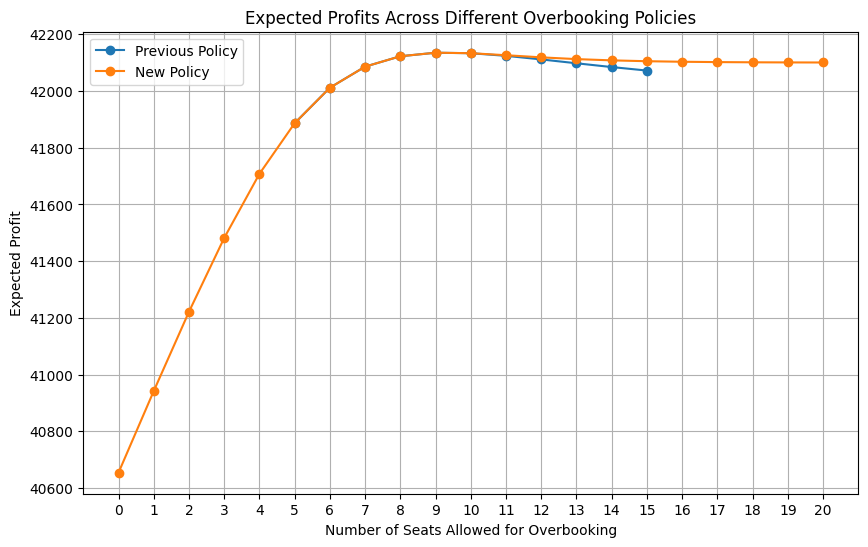

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'overbooking_values' and 'expected_profits' are defined as mentioned
# We also assume that 'expected_profits2' is available and corresponds to the new policy

# First, we ensure 'overbooking_values' is correctly defined for both cases
overbooking_values = np.arange(5, 16)

# Then, we plot both sets of data
plt.figure(figsize=(10, 6))
plt.plot(overbooking_values, expected_profits, '-o', label='Previous Policy')
plt.plot(overbooking_values_policy2, expected_profits_policy2, '-o', label='New Policy')
plt.title('Expected Profits Across Different Overbooking Policies')
plt.xlabel('Number of Seats Allowed for Overbooking')
plt.xticks(np.arange(0, 21, 1))
plt.ylabel('Expected Profit')
plt.grid(True)
plt.legend()
plt.show()

### Simulation

In [ ]:
def run_single_plane_sim(price_selection_policy, price_comb, prob_comb, overbooking):
    # initialize our plane
    coach_seats_sold = 0
    first_seats_sold = 0
    profit = 0
    revenue = 0
    overbooking_cost = 0

    # simulate each day
    for ti in range(T-1):
        # decide coach and first prices
        price_selection = int(price_selection_policy[coach_seats_sold][first_seats_sold][ti])

        # sell coach?
        if coach_seats_sold < coach_seats + overbooking:
            sold_coach = np.random.binomial(1,prob_comb[price_selection][0]) if first_seats_sold < first_seats else np.random.binomial(1,prob_comb[price_selection][0]+0.03)
        else:
            sold_coach = 0

        # sell first?
        if first_seats_sold < first_seats:
            sold_first = np.random.binomial(1,prob_comb[price_selection][1])
        else:
            sold_first = 0

        ### Validate with Dan if the discount should be in the simulation
        #                (sold coach * price coach day           +   sold first * price first of day)        * discounted of that day
        day_profit = (sold_coach*price_comb[price_selection][0] + sold_first*price_comb[price_selection][1]) * (daily_d**ti)
        coach_seats_sold += sold_coach
        first_seats_sold += sold_first
        revenue += day_profit

        # print(f'Day: {ti}, price_selection: {price_comb[price_selection]}, sold_coach: {sold_coach}, sold_first: {sold_first}, day_profit: {day_profit}, sum profit: {profit}')

    # day of plane depart show up simulation
    print('----------------------------------------------------------------------------------------------------------------------')
    print(f'Plane status, coach_tickets_sold: {coach_seats_sold}, first_tickets_sold: {first_seats_sold}')
    showup_coach = np.random.binomial(coach_seats_sold, coach_showup_prob)
    showup_first = np.random.binomial(first_seats_sold, first_showup_prob)
    profit = revenue

    # overbooking has occurred
    if showup_coach > coach_seats:
        overbook = showup_coach - coach_seats
        free_seats_first = first_seats - showup_first
        assigned_to_first = overbook if free_seats_first > overbook else free_seats_first

        # Value function = (cost of upgrading to first class + cost of bumping of the plane)
        overbooking_cost = (upgrade_cost*assigned_to_first + bump_cost*(overbook-assigned_to_first))
        profit = revenue - overbooking_cost

    print(f'Plane status at take off, coach_showup: {showup_coach}, first_showup: {showup_first}, profit: {profit}')

    return coach_seats_sold, first_seats_sold, revenue, showup_coach, showup_first, overbooking_cost, profit

price_comb = np.array([[coach_price_L, first_price_L], [coach_price_L, first_price_H], [coach_price_H, first_price_L], [coach_price_H, first_price_H]])
prob_comb = np.array([[coach_L_sale_prob, first_L_sale_prob], [coach_L_sale_prob, first_H_sale_prob], [coach_H_sale_prob, first_L_sale_prob], [coach_H_sale_prob, first_H_sale_prob]])
run_single_plane_sim(pricing_policy[0], price_comb, prob_comb, 5)

----------------------------------------------------------------------------------------------------------------------
Plane status, coach_tickets_sold: 105, first_tickets_sold: 15
Plane status at take off, coach_showup: 99, first_showup: 14, profit: 39235.50903339337


(105, 15, 39235.50903339337, 99, 14, 0, 39235.50903339337)

In [ ]:
"""
This section of the code runs the simulation n_sim times

Re use this section of code to compare with different overbooking policies
"""


# Simulation Variables
n_sim = 5000

sim_coach_seats_sold = np.zeros(n_sim)
sim_first_seats_sold = np.zeros(n_sim)
sim_revs = np.zeros(n_sim)
sim_showup_coach = np.zeros(n_sim)
sim_showup_first = np.zeros(n_sim)
sim_overbook_cost = np.zeros(n_sim)
sim_profits = np.zeros(n_sim)


# Setting Variables
price_comb = np.array([[coach_price_L, first_price_L], [coach_price_L, first_price_H], [coach_price_H, first_price_L], [coach_price_H, first_price_H]])
prob_comb = np.array([[coach_L_sale_prob, first_L_sale_prob], [coach_L_sale_prob, first_H_sale_prob], [coach_H_sale_prob, first_L_sale_prob], [coach_H_sale_prob, first_H_sale_prob]])
policy = pricing_policy[4]
overbooking = 9

for i in range(n_sim):
    sim_res = run_single_plane_sim(policy, price_comb, prob_comb, overbooking)
    sim_coach_seats_sold[i] = sim_res[0]
    sim_first_seats_sold[i] = sim_res[1]
    sim_revs[i] = sim_res[2]
    sim_showup_coach[i] = sim_res[3]
    sim_showup_first[i] = sim_res[4]
    sim_overbook_cost[i] = sim_res[5]
    sim_profits[i] = sim_res[6]

Streaming output truncated to the last 5000 lines.
Plane status, coach_tickets_sold: 108, first_tickets_sold: 20
Plane status at take off, coach_showup: 100, first_showup: 20, profit: 43537.78851871006
----------------------------------------------------------------------------------------------------------------------
Plane status, coach_tickets_sold: 109, first_tickets_sold: 20
Plane status at take off, coach_showup: 102, first_showup: 19, profit: 43444.60981727005
----------------------------------------------------------------------------------------------------------------------
Plane status, coach_tickets_sold: 106, first_tickets_sold: 19
Plane status at take off, coach_showup: 102, first_showup: 18, profit: 41714.93378832609
----------------------------------------------------------------------------------------------------------------------
Plane status, coach_tickets_sold: 109, first_tickets_sold: 20
Plane status at take off, coach_showup: 105, first_showup: 20, profit: 40841.

In [ ]:
np.mean(sim_revs)

42880.23087404409

In [ ]:
np.mean(sim_showup_first)

18.9908

In [ ]:
#Frequency of Coach Overbooking and Passengers Bumped
def calculate_overbooking_statistics(sim_showup_coach, coach_seats):
    overbooked_flights = sim_showup_coach > coach_seats
    num_overbooked_flights = np.sum(overbooked_flights)
    return num_overbooked_flights, overbooked_flights

# This code will be used after you have simulated the flights with 'n_sim' times.
# Make sure to run this after the simulation loop.
num_overbooked_flights, overbooked_flights = calculate_overbooking_statistics(sim_showup_coach, coach_seats)
print(f"Number of times coach was overbooked: {num_overbooked_flights}")
print(f"Frequency of overbooking: {num_overbooked_flights / n_sim}")


Number of times coach was overbooked: 3901
Frequency of overbooking: 0.7802


In [ ]:
#Average and Volatility of Overbooking Cost
def calculate_overbooking_costs(sim_overbook_cost):
    average_overbooking_cost = np.mean(sim_overbook_cost)
    overbooking_cost_std_dev = np.std(sim_overbook_cost)
    return average_overbooking_cost, overbooking_cost_std_dev

average_overbooking_cost, overbooking_cost_std_dev = calculate_overbooking_costs(sim_overbook_cost)
print(f"Average overbooking cost: {average_overbooking_cost}")
print(f"Volatility of overbooking cost (Standard Deviation): {overbooking_cost_std_dev}")


Average overbooking cost: 895.72
Volatility of overbooking cost (Standard Deviation): 855.1006850657998


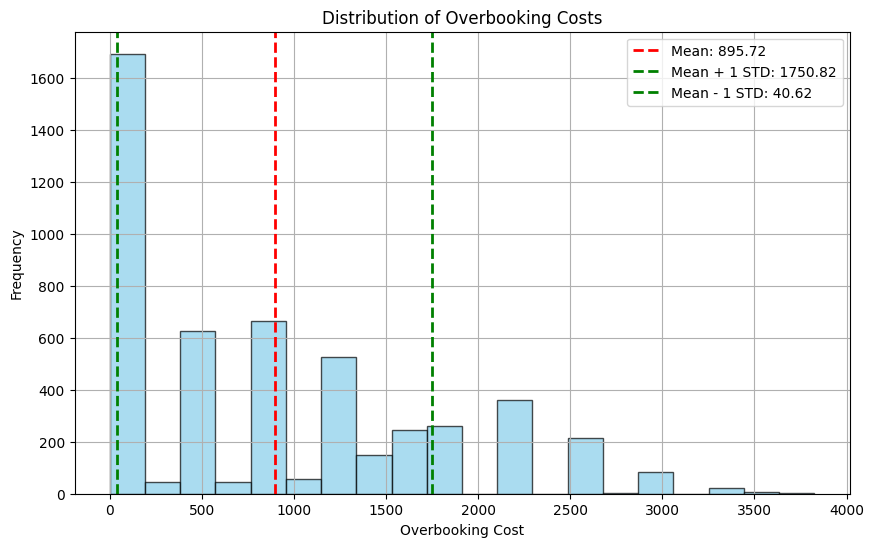

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_histogram_with_annotations(data, title, xlabel, ylabel, mean, std_dev):
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=20, alpha=0.7, color='skyblue', edgecolor='black')

    # Add a vertical line for the average
    plt.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean:.2f}')

    # Add vertical lines for one standard deviation above and below the mean
    plt.axvline(mean + std_dev, color='green', linestyle='--', linewidth=2, label=f'Mean + 1 STD: {mean + std_dev:.2f}')
    plt.axvline(mean - std_dev, color='green', linestyle='--', linewidth=2, label=f'Mean - 1 STD: {mean - std_dev:.2f}')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming you have these variables defined as per your message
average_overbooking_cost = np.mean(sim_overbook_cost) # If not already defined
overbooking_cost_std_dev = np.std(sim_overbook_cost) # If not already defined

# Now call the function with your specific data
plot_histogram_with_annotations(sim_overbook_cost, 'Distribution of Overbooking Costs', 'Overbooking Cost', 'Frequency', average_overbooking_cost, overbooking_cost_std_dev)






In [ ]:
#Average Profit and Volatility of profits
def analyze_profits(sim_profits):
    average_profit = np.mean(sim_profits)
    profit_std_dev = np.std(sim_profits)
    return average_profit, profit_std_dev

average_profit, profit_std_dev = analyze_profits(sim_profits)
print(f"Average profit: {average_profit}")
print(f"Volatility of profits (Standard Deviation): {profit_std_dev}")


Average profit: 41984.51087404409
Volatility of profits (Standard Deviation): 990.9839984993052


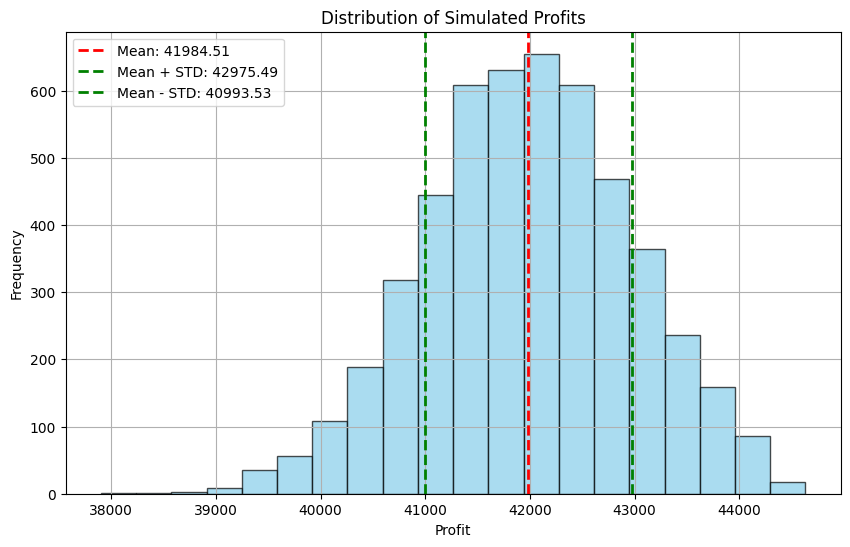

In [ ]:
def plot_histogram(data, title, xlabel, ylabel):
    # Calculate mean and standard deviation within the function
    mean = np.mean(data)
    std_dev = np.std(data)

    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=20, alpha=0.7, color='skyblue', edgecolor='black')

    # Add lines for mean and standard deviation
    plt.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean:.2f}')
    plt.axvline(mean + std_dev, color='green', linestyle='--', linewidth=2, label=f'Mean + STD: {mean + std_dev:.2f}')
    plt.axvline(mean - std_dev, color='green', linestyle='--', linewidth=2, label=f'Mean - STD: {mean - std_dev:.2f}')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

# Call this function for different data points you want to analyze
# For example, to plot a histogram of profits:
plot_histogram(sim_profits, 'Distribution of Simulated Profits', 'Profit', 'Frequency')


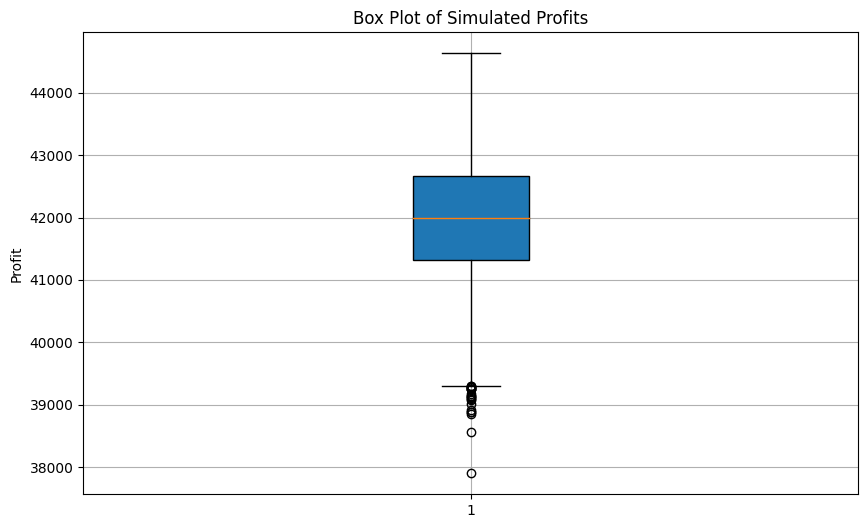

In [ ]:
def plot_boxplot(data, title, ylabel):
    plt.figure(figsize=(10, 6))
    plt.boxplot(data, vert=True, patch_artist=True)  # `vert=False` would make the boxplot horizontal
    plt.title(title)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

# Plot a boxplot for simulated profits to analyze volatility
plot_boxplot(sim_profits, 'Box Plot of Simulated Profits', 'Profit')



Average profit per seat: 329.15580305295316


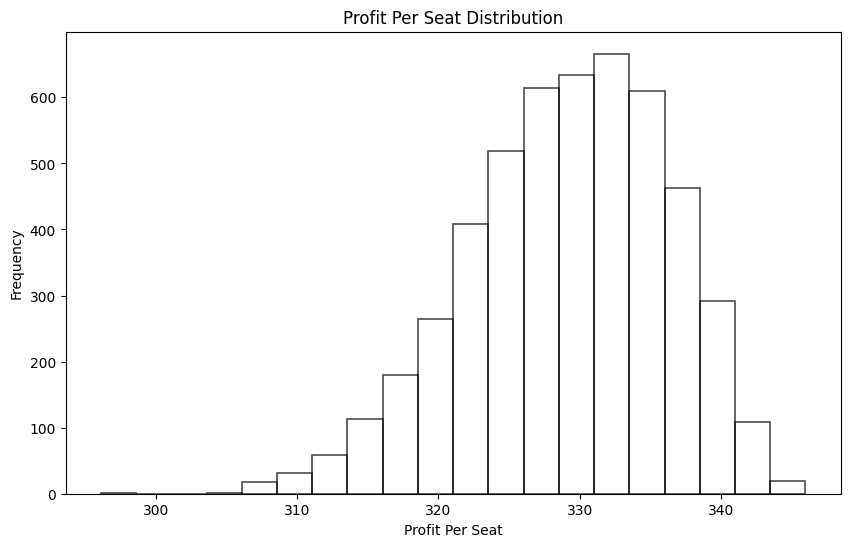

In [ ]:
def profit_per_seat(sim_profits, sim_coach_seats_sold, sim_first_seats_sold):
    total_seats_sold = sim_coach_seats_sold + sim_first_seats_sold
    return sim_profits / total_seats_sold

def plot_histogram2(data, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=20, alpha=0.7, edgecolor='black', linewidth=1.2, fill=False)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(False)  # Grid removed
    plt.show()

# The rest of your code remains the same
profits_per_seat = profit_per_seat(sim_profits, sim_coach_seats_sold, sim_first_seats_sold)
average_profit_per_seat = np.mean(profits_per_seat)
print(f"Average profit per seat: {average_profit_per_seat}")

# Plot the histogram for profit per seat with the updated style
plot_histogram2(profits_per_seat, 'Profit Per Seat Distribution', 'Profit Per Seat', 'Frequency')



#### Simulation for second policy

In [ ]:
"""
This section of the code runs the simulation n_sim times

Re use this section of code to compare with different overbooking policies
"""


# Simulation Variables
n_sim = 5000

sim_coach_seats_sold = np.zeros(n_sim)
sim_first_seats_sold = np.zeros(n_sim)
sim_revs = np.zeros(n_sim)
sim_showup_coach = np.zeros(n_sim)
sim_showup_first = np.zeros(n_sim)
sim_overbook_cost = np.zeros(n_sim)
sim_profits = np.zeros(n_sim)


# Setting Variables
price_comb_new = np.array([[coach_price_L, first_price_L], [coach_price_L, first_price_H], [coach_price_H, first_price_L], [coach_price_H, first_price_H], [0, first_price_L], [0, first_price_H]])
prob_comb_new = np.array([[coach_L_sale_prob, first_L_sale_prob], [coach_L_sale_prob, first_H_sale_prob], [coach_H_sale_prob, first_L_sale_prob], [coach_H_sale_prob, first_H_sale_prob], [0, first_L_sale_prob], [0, first_H_sale_prob]])
policy = pricing_policy_policy2[9]
overbooking = 9

for i in range(n_sim):
    sim_res = run_single_plane_sim(policy, price_comb_new, prob_comb_new, overbooking)
    sim_coach_seats_sold[i] = sim_res[0]
    sim_first_seats_sold[i] = sim_res[1]
    sim_revs[i] = sim_res[2]
    sim_showup_coach[i] = sim_res[3]
    sim_showup_first[i] = sim_res[4]
    sim_overbook_cost[i] = sim_res[5]
    sim_profits[i] = sim_res[6]

Streaming output truncated to the last 5000 lines.
Plane status, coach_tickets_sold: 109, first_tickets_sold: 19
Plane status at take off, coach_showup: 104, first_showup: 19, profit: 41445.310974192944
----------------------------------------------------------------------------------------------------------------------
Plane status, coach_tickets_sold: 109, first_tickets_sold: 19
Plane status at take off, coach_showup: 105, first_showup: 19, profit: 41267.494965566104
----------------------------------------------------------------------------------------------------------------------
Plane status, coach_tickets_sold: 107, first_tickets_sold: 20
Plane status at take off, coach_showup: 102, first_showup: 18, profit: 41559.596670671664
----------------------------------------------------------------------------------------------------------------------
Plane status, coach_tickets_sold: 109, first_tickets_sold: 18
Plane status at take off, coach_showup: 104, first_showup: 17, profit: 407

In [ ]:
#Frequency of Coach Overbooking and Passengers Bumped

# This code will be used after you have simulated the flights with 'n_sim' times.
# Make sure to run this after the simulation loop.
num_overbooked_flights, overbooked_flights = calculate_overbooking_statistics(sim_showup_coach, coach_seats)
print(f"Number of times coach was overbooked: {num_overbooked_flights}")
print(f"Frequency of overbooking: {num_overbooked_flights / n_sim}")

Number of times coach was overbooked: 3934
Frequency of overbooking: 0.7868


In [ ]:
#Average and Volatility of Overbooking Cost

average_overbooking_cost, overbooking_cost_std_dev = calculate_overbooking_costs(sim_overbook_cost)
print(f"Average overbooking cost: {average_overbooking_cost}")
print(f"Volatility of overbooking cost (Standard Deviation): {overbooking_cost_std_dev}")

Average overbooking cost: 934.31
Volatility of overbooking cost (Standard Deviation): 876.9907775455794


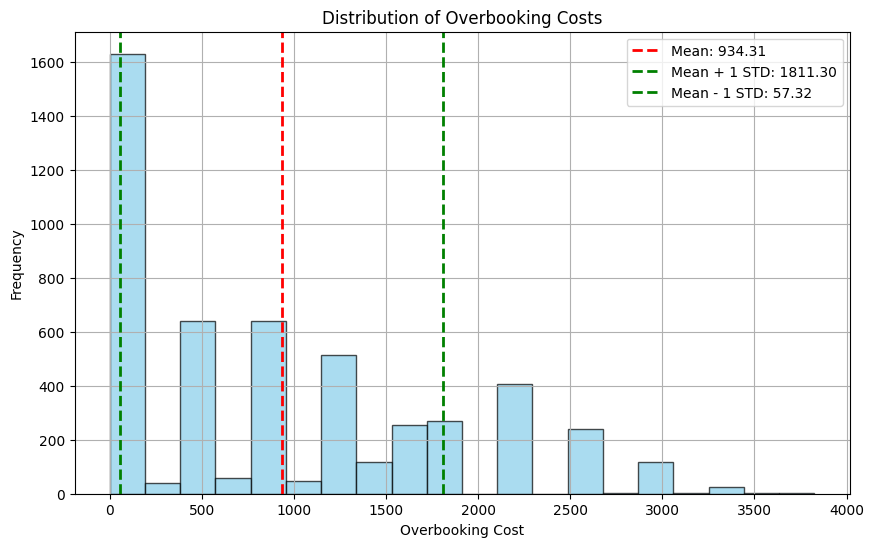

In [ ]:
# Assuming you have these variables defined as per your message
average_overbooking_cost = np.mean(sim_overbook_cost) # If not already defined
overbooking_cost_std_dev = np.std(sim_overbook_cost) # If not already defined

# Now call the function with your specific data
plot_histogram_with_annotations(sim_overbook_cost, 'Distribution of Overbooking Costs', 'Overbooking Cost', 'Frequency', average_overbooking_cost, overbooking_cost_std_dev)

In [ ]:
#Average Profit and Volatility of profits

average_profit, profit_std_dev = analyze_profits(sim_profits)
print(f"Average profit: {average_profit}")
print(f"Volatility of profits (Standard Deviation): {profit_std_dev}")

Average profit: 41975.42379667542
Volatility of profits (Standard Deviation): 991.712233231617


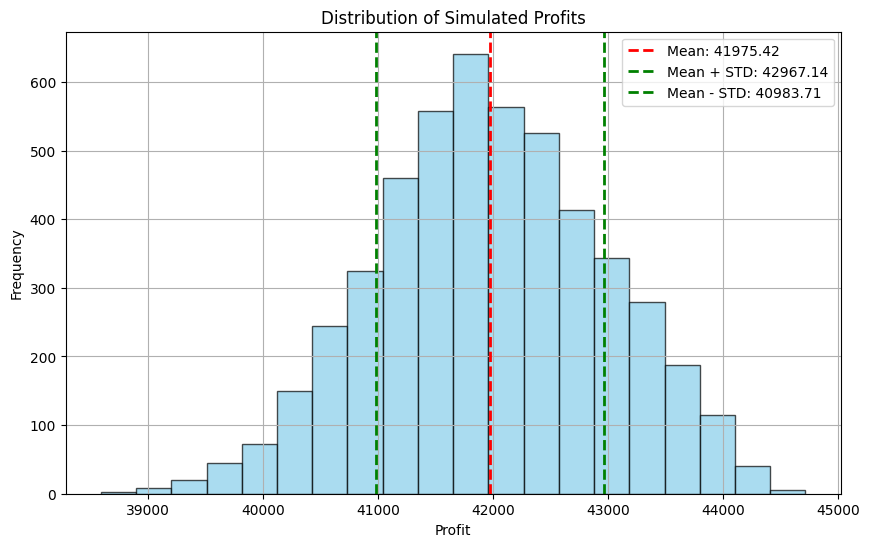

In [ ]:
# Call this function for different data points you want to analyze
# For example, to plot a histogram of profits:
plot_histogram(sim_profits, 'Distribution of Simulated Profits', 'Profit', 'Frequency')

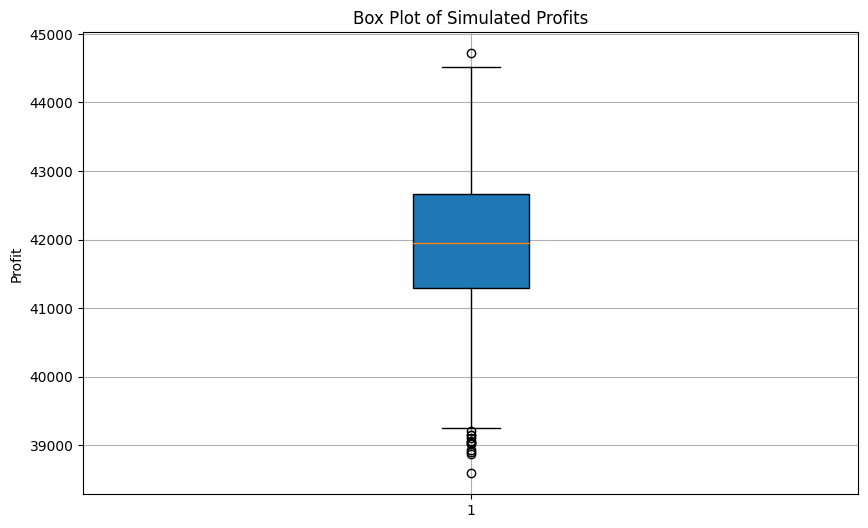

In [ ]:
# Plot a boxplot for simulated profits to analyze volatility
plot_boxplot(sim_profits, 'Box Plot of Simulated Profits', 'Profit')

Average profit per seat: 328.9338474868358


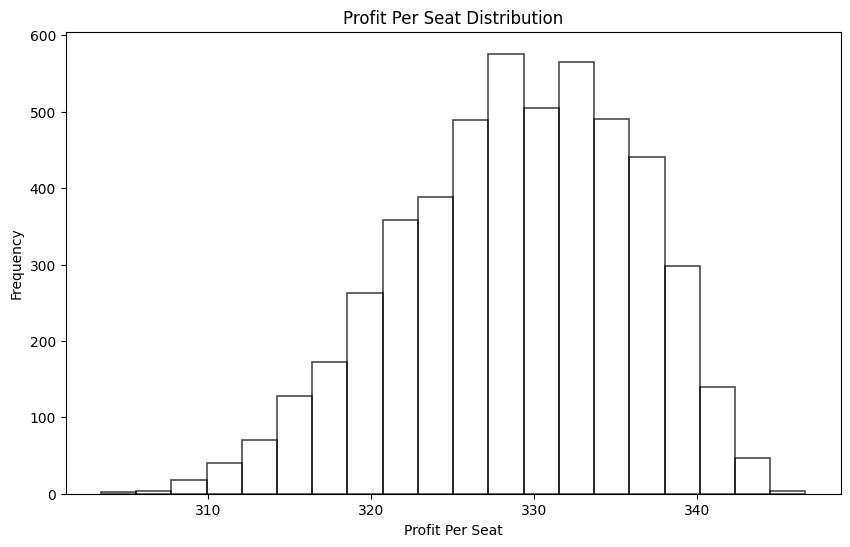

In [ ]:
# The rest of your code remains the same
profits_per_seat = profit_per_seat(sim_profits, sim_coach_seats_sold, sim_first_seats_sold)
average_profit_per_seat = np.mean(profits_per_seat)
print(f"Average profit per seat: {average_profit_per_seat}")

# Plot the histogram for profit per seat with the updated style
plot_histogram2(profits_per_seat, 'Profit Per Seat Distribution', 'Profit Per Seat', 'Frequency')